In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Load data
df = pd.read_csv("C:/Users/sudhe/Downloads/Sudherssp/Stock prediction/final_cleaned_merged_stock_data.csv")
print("Columns:", df.columns.tolist()[:10], "…")  # show some columns for context

# Drop initial rows with missing values (if any)
df = df.dropna().reset_index(drop=True)

# Define Trend target based on next-day price change
df['Trend'] = df['Change %'].shift(-1)
df.dropna(subset=['Trend'], inplace=True)  # drop last row with undefined next-day trend

# Encode Trend as Bullish, Bearish, Neutral
def categorize_trend(x):
    if x > 0.01:
        return 'Bullish'
    elif x < -0.01:
        return 'Bearish'
    else:
        return 'Neutral'
df['Trend'] = df['Trend'].apply(categorize_trend)

# Confirm class distribution
print("Trend class counts:\n", df['Trend'].value_counts())

# Split into training and test sets (chronologically)
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size].copy()
test_data = df.iloc[train_size:].copy()

# Separate features and target
X_train = train_data.drop(columns=['date', 'Trend'])
y_train = train_data['Trend']
X_test = test_data.drop(columns=['date', 'Trend'])
y_test = test_data['Trend']

print("Training samples:", len(X_train), "Test samples:", len(X_test))


Columns: ['INTC', 'ASML', 'AMAT', 'AMD', 'QCOM', 'TSM', 'TXN', 'AVGO', 'NVDA', 'date'] …
Trend class counts:
 Trend
Bearish    461
Bullish    448
Neutral    362
Name: count, dtype: int64
Training samples: 1016 Test samples: 255


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Encode target labels as integers for modeling
label_mapping = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}
y_train_enc = y_train.map(label_mapping).values
y_test_enc = y_test.map(label_mapping).values

# Initialize models
# --- Classifier Definitions (updated) ---

# 1) Logistic Regression: raise max_iter (or switch solver) to ensure convergence
log_clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=5000,       # ↑ from 1000 to 5000
    random_state=0
)

# 2) SVM remains the same
svm_clf = SVC(
    kernel='rbf',
    C=1,
    probability=True,
    random_state=0
)

# 3) XGBoost: drop deprecated use_label_encoder
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    subsample=0.8,
    eval_metric='mlogloss',
    random_state=0
)


# Train models
log_clf.fit(X_train, y_train_enc)
svm_clf.fit(X_train, y_train_enc)
xgb_clf.fit(X_train, y_train_enc)

# Stacking ensemble (meta-learner: Logistic Regression on SVM & XGB predictions)
from sklearn.ensemble import StackingClassifier
ensemble_clf = StackingClassifier(
    estimators=[('svm', svm_clf), ('xgb', xgb_clf)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5)
ensemble_clf.fit(X_train, y_train_enc)

# Evaluate models on test set
from sklearn.metrics import accuracy_score, f1_score
models = {
    "Logistic Regression": log_clf,
    "SVM (RBF Kernel)": svm_clf,
    "XGBoost": xgb_clf,
    "Stacking Ensemble": ensemble_clf
}
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    f1 = f1_score(y_test_enc, y_pred, average='weighted')
    print(f"{name}: Accuracy = {acc:.3f}, Weighted F1 = {f1:.3f}")


Logistic Regression: Accuracy = 0.333, Weighted F1 = 0.211
SVM (RBF Kernel): Accuracy = 0.357, Weighted F1 = 0.188
XGBoost: Accuracy = 0.380, Weighted F1 = 0.333
Stacking Ensemble: Accuracy = 0.431, Weighted F1 = 0.353


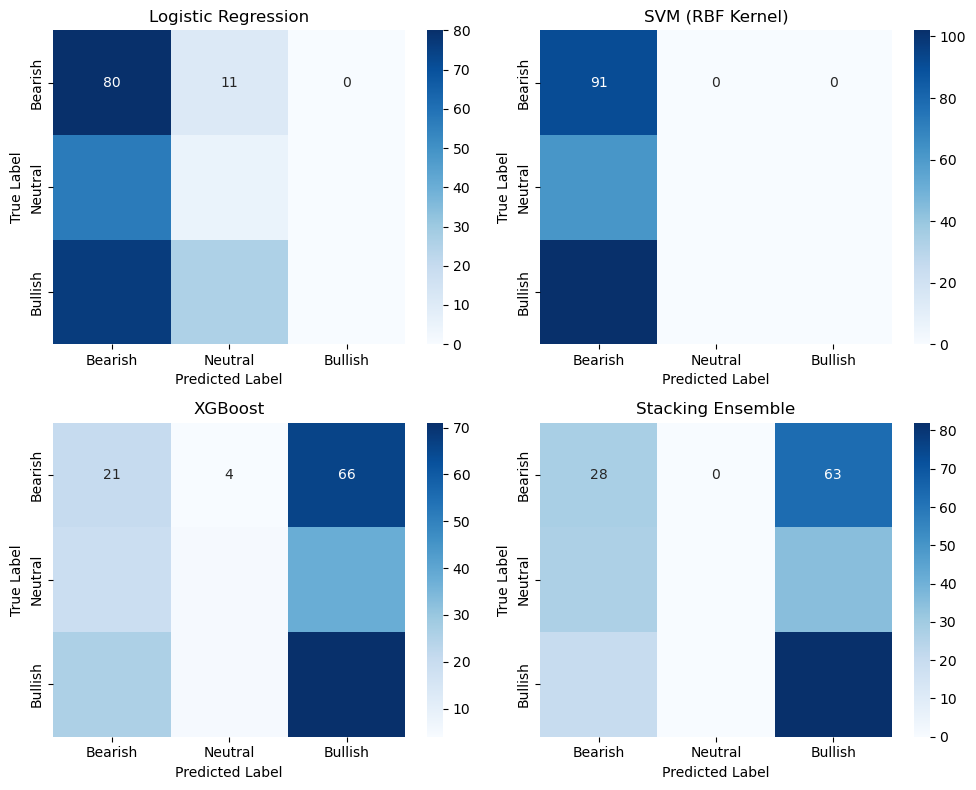

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ['Bearish', 'Neutral', 'Bullish']

# Plot confusion matrix for each model
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()
for idx, (name, model) in enumerate(models.items()):
    cm = confusion_matrix(y_test_enc, model.predict(X_test), labels=[0,1,2])
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
    axes[idx].set_title(f"{name}")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")
plt.tight_layout()
plt.show()

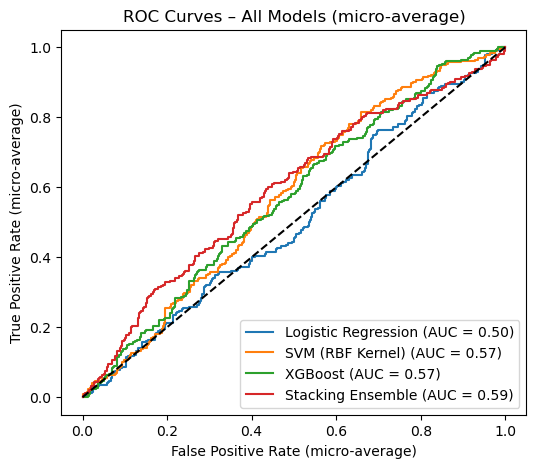

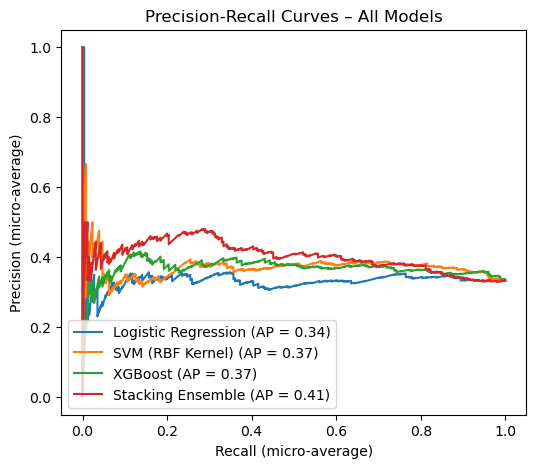

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Binarize the true labels for multiclass ROC/PR computation
Y_test_bin = label_binarize(y_test_enc, classes=[0,1,2])

# Prepare to plot ROC and PR for all models
plt.figure(figsize=(6,5))
for name, model in models.items():
    # Get probability scores for each class
    y_score = model.predict_proba(X_test)
    # Compute micro-average ROC
    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_score.ravel())
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_val:.2f})")
plt.plot([0,1],[0,1],'k--')  # random classifier line
plt.xlabel("False Positive Rate (micro-average)")
plt.ylabel("True Positive Rate (micro-average)")
plt.title("ROC Curves – All Models (micro-average)")
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(6,5))
for name, model in models.items():
    y_score = model.predict_proba(X_test)
    precision, recall, _ = precision_recall_curve(Y_test_bin.ravel(), y_score.ravel())
    ap_val = average_precision_score(Y_test_bin, y_score, average='micro')
    plt.plot(recall, precision, label=f"{name} (AP = {ap_val:.2f})")
plt.xlabel("Recall (micro-average)")
plt.ylabel("Precision (micro-average)")
plt.title("Precision-Recall Curves – All Models")
plt.legend(loc="lower left")
plt.show()


Top positive coefficients (Bullish class):
  Price: 0.025
  GPRA: 0.012
  GPRH_BASIC: 0.006
  GPRH_AND: 0.005
  GPRH_NOEW: 0.004
Top negative coefficients (Bullish class):
  GPR_AND: -0.016
  GPR_NOEW: -0.009
  Low: -0.008
  High: -0.008
  Open: -0.008


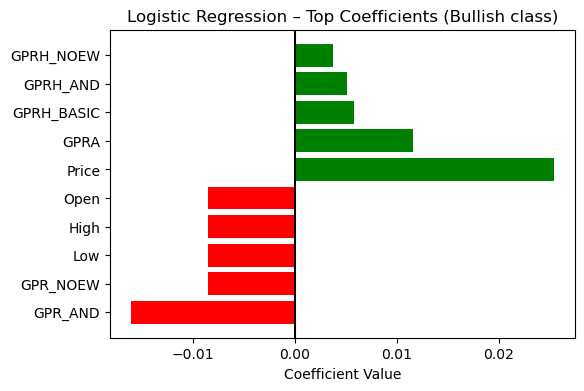

In [8]:
import numpy as np

# Get coefficient vector for Bullish class (assuming encoded as index 2)
class_index = label_mapping['Bullish']  # which is 2
coef_bullish = log_clf.coef_[class_index]

# Identify top 5 positive and top 5 negative coefficients
feature_names = X_train.columns  # feature names
top_pos_indices = np.argsort(coef_bullish)[-5:][::-1]   # indices of 5 largest positive coeff
top_neg_indices = np.argsort(coef_bullish)[:5]          # indices of 5 most negative coeff

top_pos_features = feature_names[top_pos_indices]
top_neg_features = feature_names[top_neg_indices]
top_pos_vals = coef_bullish[top_pos_indices]
top_neg_vals = coef_bullish[top_neg_indices]

print("Top positive coefficients (Bullish class):")
for feat, val in zip(top_pos_features, top_pos_vals):
    print(f"  {feat}: {val:.3f}")
print("Top negative coefficients (Bullish class):")
for feat, val in zip(top_neg_features, top_neg_vals):
    print(f"  {feat}: {val:.3f}")

# Plot horizontal bar chart for coefficients
import matplotlib.pyplot as plt
top_features = list(top_neg_features) + list(top_pos_features)
top_values = list(top_neg_vals) + list(top_pos_vals)
colors = ['red']*5 + ['green']*5  # red for negative, green for positive
plt.figure(figsize=(6,4))
y_pos = np.arange(len(top_features))
plt.barh(y_pos, top_values, color=colors)
plt.yticks(y_pos, top_features)
plt.axvline(0, color='black')
plt.title("Logistic Regression – Top Coefficients (Bullish class)")
plt.xlabel("Coefficient Value")
plt.show()


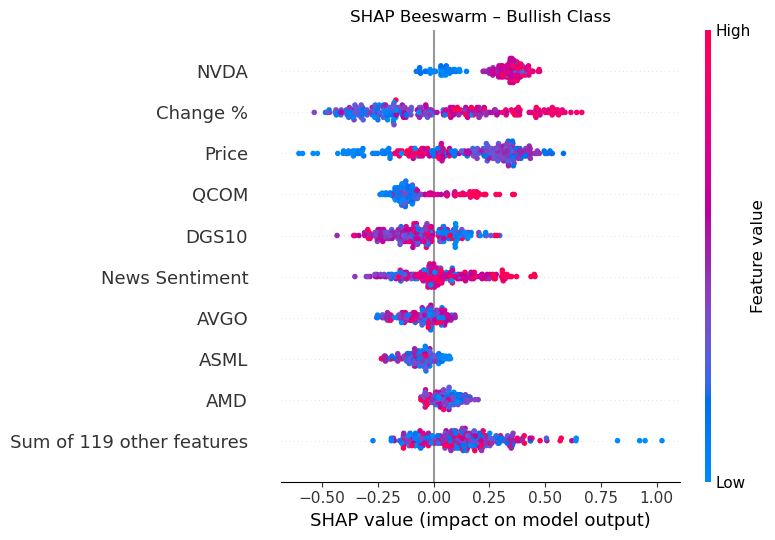

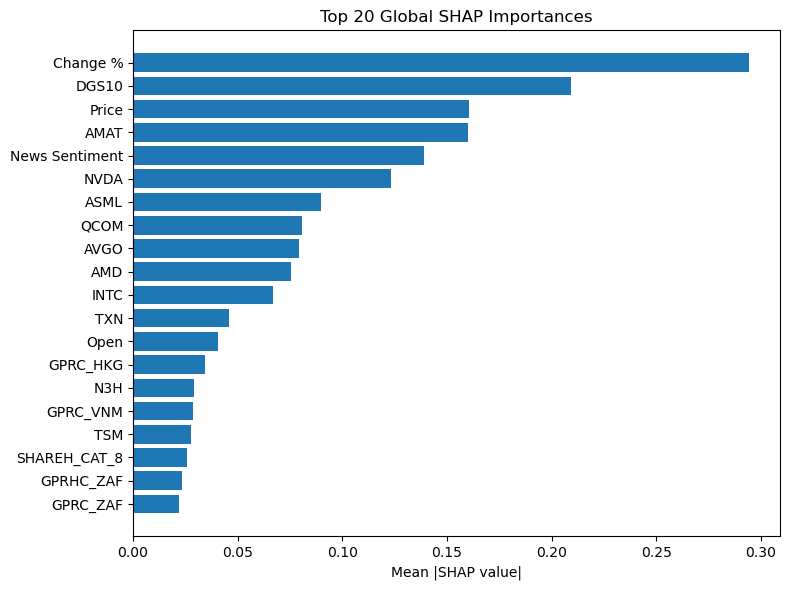

In [11]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1) Prepare a purely numeric test matrix
X_test_clean = X_test.select_dtypes(include=[np.number]).copy()

# 2) Get an Explanation object
explainer = shap.TreeExplainer(xgb_clf)
shap_exp = explainer(X_test_clean)  
# shap_exp.values has shape (n_samples, n_features, n_classes)

# 3) Beeswarm (dot) plot for the Bullish class (encoded as 2)
bull_exp = shap_exp[..., 2]   # slice out the Bullish‐class Explanation
shap.plots.beeswarm(bull_exp, show=False)
plt.title("SHAP Beeswarm – Bullish Class")
plt.tight_layout()
plt.show()

# 4) Global mean |SHAP| importance bar chart
# Compute mean absolute SHAP across samples AND across classes
abs_vals = np.abs(shap_exp.values)             # shape (n_samples, n_features, n_classes)
mean_abs = abs_vals.mean(axis=(0, 2))          # shape (n_features,)

# Plot
feat_names = X_test_clean.columns.tolist()
inds = np.argsort(mean_abs)[::-1]              # sort descending
plt.figure(figsize=(8,6))
plt.barh([feat_names[i] for i in inds[:20]], mean_abs[inds[:20]])
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Global SHAP Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Numeric feature columns:
 ['INTC', 'ASML', 'AMAT', 'AMD', 'QCOM', 'TSM', 'TXN', 'AVGO', 'NVDA', 'Price', 'Open', 'High', 'Low', 'Change %', 'GPR', 'GPRT', 'GPRA', 'GPRH', 'GPRHT', 'GPRHA'] ...
Kruskal-Wallis H-statistic: 382.552, p-value: 1.332e-82


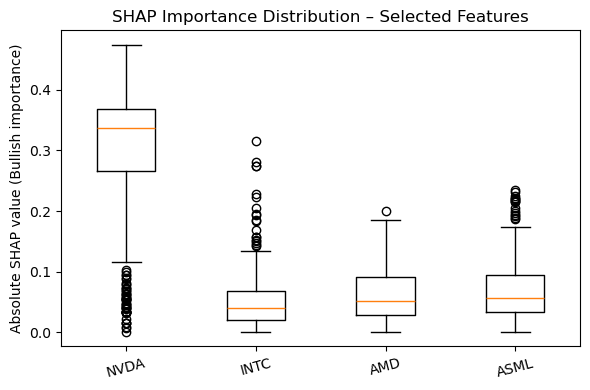

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import shap

# --- 1) Inspect your numeric feature columns to get exact names ---
X_test_clean = X_test.select_dtypes(include=[np.number]).copy()
print("Numeric feature columns:\n", X_test_clean.columns.tolist()[:20], "...")

# Now pick the exact names from the printed list:
features_to_compare = [
    'NVDA',    
    'INTC',     
    'AMD',      
    'ASML'     
]

# --- 2) Use the new SHAP API to get an Explanation object ---
explainer = shap.TreeExplainer(xgb_clf)
shap_exp = explainer(X_test_clean)    # shap_exp.values shape = (n_samples, n_features, n_classes)

# Slice out the Bullish‐class SHAP values
bull_idx = label_mapping['Bullish']   # 2
shap_bull = shap_exp.values[..., bull_idx]  # shape = (n_samples, n_features)

# --- 3) Build absolute‐value distributions for each feature ---
shap_distributions = [
    np.abs(shap_bull[:, X_test_clean.columns.get_loc(f)]) 
    for f in features_to_compare
]

# --- 4) Kruskal–Wallis test ---
H, p_value = kruskal(*shap_distributions)
print(f"Kruskal-Wallis H-statistic: {H:.3f}, p-value: {p_value:.3e}")

# --- 5) Boxplot of distributions ---
plt.figure(figsize=(6,4))
plt.boxplot(shap_distributions, labels=features_to_compare)
plt.ylabel("Absolute SHAP value (Bullish importance)")
plt.title("SHAP Importance Distribution – Selected Features")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
